In [1]:
!pip install -q  ds-ctcdecoder
!pip install -q gdown streamlit 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tfx-bsl 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.
tfx-bsl 1.5.0 requires protobuf<4,>=3.13, but you have protobuf 4.24.4 which is incompatible.
tfx-bsl 1.5.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.1 which is incompatible.
tfx-bsl 1.5.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,<3,>=1.15.2, but you have tensorflow 2.6.2 which is incompatible.
tensorflow 2.6.2 requires numpy~=1.19.2, but y

In [2]:
# https://drive.google.com/file/d/1SMzelSj_y-fZI_EffAFu7RQXA5yS6lN5/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1SMzelSj_y-fZI_EffAFu7RQXA5yS6lN5' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1SMzelSj_y-fZI_EffAFu7RQXA5yS6lN5" -O 'a01-000u-00.png' && rm -rf /tmp/cookies.txt

!wget https://pylessons.com/media/Tutorials/TensorFlow-CAPTCHA-solver/handwritten-sentence-recognition/166dec30-f056-48f7-aafd-fb7bec75f2fc.png -O image1.png
!wget https://pylessons.com/media/Tutorials/TensorFlow-CAPTCHA-solver/handwritten-sentence-recognition/139c8afb-c2e1-44c8-a062-af63ad209f37.png -O sample.png

--2024-04-13 02:36:00--  https://docs.google.com/uc?export=download&confirm=&id=1SMzelSj_y-fZI_EffAFu7RQXA5yS6lN5
Resolving docs.google.com (docs.google.com)... 142.250.99.100, 142.250.99.113, 142.250.99.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.99.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1SMzelSj_y-fZI_EffAFu7RQXA5yS6lN5&export=download [following]
--2024-04-13 02:36:00--  https://drive.usercontent.google.com/download?id=1SMzelSj_y-fZI_EffAFu7RQXA5yS6lN5&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.195.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43239 (42K) [image/png]
Saving to: ‘a01-000u-00.png’

a01-000u-00.png     100%[===================>]  42.23K  --.-KB/s    in 0.001s

In [3]:
#New https://drive.google.com/file/d/1SpAvRFyY6MWmhyK2pyh0K2N9IQSOGPj6/view?usp=sharing
#Old https://drive.google.com/file/d/1XZbiISEMMgIlzNZpi6HHm5CPZyGhjv3N/view?usp=sharing
!gdown "1XZbiISEMMgIlzNZpi6HHm5CPZyGhjv3N"

Downloading...
From (original): https://drive.google.com/uc?id=1XZbiISEMMgIlzNZpi6HHm5CPZyGhjv3N
From (redirected): https://drive.google.com/uc?id=1XZbiISEMMgIlzNZpi6HHm5CPZyGhjv3N&confirm=t&uuid=ba11adb4-f212-401e-959c-9fdfc3c81140
To: /kaggle/working/final_model.pth
100%|████████████████████████████████████████| 178M/178M [00:03<00:00, 53.7MB/s]


In [4]:
import os
os.makedirs('./dataset')

In [5]:
# importing the "tarfile" module
import tarfile
  
# open file
file = tarfile.open('../input/iamhandwriting/ascii.tgz')
  
# print file names
#print(file.getnames())
  
# extract files
file.extractall('./dataset')
  
# close file
file.close()

In [6]:

# open file
file = tarfile.open('../input/iamhandwriting/lines.tgz')
  
# print file names
#print(file.getnames())
  
# extract files
file.extractall('./dataset')
  
# close file
file.close()

In [7]:
import sys
import os
import cv2 as cv
import pandas as pd
import Levenshtein as leven
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform as sk_transform
import torch
from skimage.color import rgba2rgb
from colorama import Fore
from skimage import io, transform, color
from skimage.color import rgb2gray
from skimage.transform import rotate, resize
from torch import nn, optim
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset
from tqdm import tqdm
from torchvision.transforms import Normalize
#from dataset import IAMData
#from model import IAMModel
from ds_ctcdecoder import Alphabet, ctc_beam_search_decoder, Scorer
from torch.utils.model_zoo import load_url
import torchvision.models as models

import torchvision.transforms as transforms
from PIL import Image

import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
def deskew(img):
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img
    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5 * img.shape[0] * skew], [0, 1, 0]])
    img = cv.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv.WARP_INVERSE_MAP | cv.INTER_LINEAR,
                        borderMode=cv.BORDER_CONSTANT, borderValue=(255, 255, 255))
    return img


class IAMData(Dataset):

    def __init__(self, txt_file, root_dir, output_size, border_pad=(0, 0)):
        gt = []
        print("Preparing dataset...")
        # Open raw lines.txt
        for line in open(txt_file):
            # Ignore comments
            if not line.startswith("#"):
                # Split each string by whitespaces
                info = line.strip().split()
                # If string was recognized correctly
                if info[1] == 'ok':
                    # First column is filename, second column is target sentence
                    gt.append((info[0] + '.png', ' '.join(info[8:]).replace('|', ' ').lower()))

        # Convert target array to Dataframe
        df = pd.DataFrame(gt, columns=['file', 'word'])
        self.line_df = df
        # Compute char set
        chars = []
        # Take all values from the last column, convert to chars and add them to array
        self.line_df.iloc[:, -1].apply(lambda x: chars.extend(list(x)))
        self.all_lines = ' '
        # Remove duplicates
        chars = sorted(list(set(chars)))
        # Convert to dictionary like {1:'c'}
        self.char_dict = {c: i for i, c in enumerate(chars)}
        # Convert raw data to dataset
        self.samples = {}
        progress_bar = tqdm(total=len(self.line_df),
                            position=0, leave=True,
                            file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.RED, Fore.RESET))
        for idx in range(0, len(self.line_df)):
            # Take image filename from the first column
            img_name = self.line_df.iloc[idx, 0]
            # Split filename by dash to get the full path
            im_nm_split = img_name.split('-')
            # Get the first level folder
            start_folder = im_nm_split[0]
            # Get the second level folder
            src_folder = '-'.join(im_nm_split[:2])
            # Target folder is ready
            folder_name = os.path.join(start_folder, src_folder)
            # Calculate the full path to the image
            img_filepath = os.path.join(root_dir,
                                        folder_name,
                                        img_name)
            # Read target image
            image = io.imread(img_filepath)
            # Read target sentence
            word = self.line_df.iloc[idx, -1]
            self.all_lines = self.all_lines + ' ' + word
            # Calculate resulting size like target_size - borders
            resize = (output_size[0] - border_pad[0], output_size[1] - border_pad[1])
            # Get height and width of the image
            h, w = image.shape[:2]
            # Calculate width and height scaling to the target size
            fx = w / resize[1]
            fy = h / resize[0]
            # Get the maximum scale
            f = max(fx, fy)
            # Calculate new size like either maximum target dimension or scaled one min(resize[0], int(h / f)
            # max(min(resize[0], int(h / f)), 1) etc. sets the lower bound
            new_size = (max(min(resize[0], int(h / f)), 1), max(min(resize[1], int(w / f * np.random.uniform(1, 3))), 1))
            # Resize image and fill all empty area with white color
            image = transform.resize(image, new_size, preserve_range=True, mode='constant', cval=255)
            image = deskew(image)
            # Prepare canvas for the resized image
            canvas = np.ones(output_size, dtype=np.uint8) * 255
            # Calculate maximum actual padding
            v_pad_max = output_size[0] - new_size[0]
            h_pad_max = output_size[1] - new_size[1]
            # Generate new padding to place image somewhere between 0 and pad_max
            v_pad = int(np.random.choice(np.arange(0, v_pad_max + 1), 1))
            h_pad = int(np.random.choice(np.arange(0, h_pad_max + 1), 1))
            # Place image
            canvas[v_pad:v_pad + new_size[0], h_pad:h_pad + new_size[1]] = image
            # Rotate image 90 degrees counter-clockwise
            canvas = transform.rotate(canvas, -90, resize=True)[:, :-1]
            # Convert to RGB from greyscale
            canvas = color.gray2rgb(canvas)
            # Transpose tensor
            canvas = torch.from_numpy(canvas.transpose((2, 0, 1))).float()
            # Normalize image
            norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            sample = {'image': norm(canvas), 'word': word}
            progress_bar.update(1)
            self.samples[idx] = sample
        progress_bar.close()

    def __len__(self):
        return len(self.line_df)

    def __getitem__(self, idx):
        return self.samples[idx]

In [9]:
%%writefile ourmodel.py
import os, sys
import torch
from colorama import Fore
from skimage.transform import rotate, resize
from torch import nn, optim
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset
from torchvision.transforms import Normalize

from ds_ctcdecoder import Alphabet, ctc_beam_search_decoder, Scorer
from torch.utils.model_zoo import load_url
import torchvision.models as models

class CNN(nn.Module):

    def __init__(self, time_step):
        super(CNN, self).__init__()
        resnet18network = models.resnet34()
        resnet18network.load_state_dict(load_url('https://download.pytorch.org/models/resnet34-333f7ec4.pth'))
        resnet18network.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.network = torch.nn.Sequential(*(list(resnet18network.children())[:-2]))
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(time_step, 1))

    def forward(self, xb):
        #print(xb.size())
        out = self.network(xb)
        #print(out.size())
        out = self.avgpool(out)
        #print(out.size())
        #print("feature extracting ends here !")
        return out.squeeze(dim=3).transpose(1, 2)


class RNN(nn.Module):

    def __init__(self, feature_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(input_size=feature_size, hidden_size=hidden_size, num_layers=num_layers,
                            bidirectional=True, batch_first=True, dropout=0)
        self.last_conv2d = nn.Conv2d(hidden_size * 2, output_size, kernel_size=1)

    def forward(self, xb):
        #print(xb.size())
        out, _ = self.lstm(xb)
        #print(out.size())
        out = self.last_conv2d(out.permute(0, 2, 1).unsqueeze(3))
        #print(out.size())
        #print("RNN ends here !")
        return out.squeeze(3).permute((2, 0, 1))


class IAMModel(nn.Module):

    def __init__(self, time_step, feature_size,
                 hidden_size, output_size, num_rnn_layers):
        super(IAMModel, self).__init__()
        self.cnn = CNN(time_step=time_step)
        self.rnn = RNN(feature_size=feature_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_rnn_layers)
        self.time_step = time_step
        self.alphabet = Alphabet(os.path.abspath("chars.txt"))
        self.scorer = Scorer(alphabet=self.alphabet, scorer_path='../input/iam-uncased/iam_uncased.scorer', alpha=0.75, beta=1.85)

    def forward(self, xb):
        #print("IAMModel")
        #print(xb.size())
        out = self.cnn(xb)
        #print(out.size())
        out = self.rnn(out)
        #print(out.size())
        #print("IAMModel")
        return out

    def beam_search_with_lm(self, xb):
        with torch.no_grad():
            #print("beam_search_with_lm")
            #print(out.size())
            out = self.forward(xb)
            #print(out.size())
            # This tensor for each image in the batch contains probabilities of each label for each input feature
            out = out.softmax(2)
            #print(out.size())
            softmax_out = out.permute(1, 0, 2).cpu().numpy()
            char_list = []
            for i in range(softmax_out.shape[0]):
                char_list.append(ctc_beam_search_decoder(probs_seq=softmax_out[i, :], alphabet=self.alphabet, beam_size=25, scorer=self.scorer)[0][1])
        return char_list

Writing ourmodel.py


In [10]:
# ============================================= PREPARING DATASET ======================================================
dataset = IAMData(txt_file='./dataset/lines.txt',
                  root_dir='./dataset',
                  output_size=(64, 800),
                  
                  border_pad=(4, 10))

classes = ''.join(dataset.char_dict.keys())
text_file = open("chars.txt", "w", encoding='utf-8')
text_file.write('\n'.join([x if x != '#' else '\\#' for x in dataset.char_dict.keys()]))
text_file.close()


def collate(batch):
    images, words = [b.get('image') for b in batch], [b.get('word') for b in batch]
    images = torch.stack(images, 0)
    # Calculate target lengths for the current batch
    lengths = [len(word) for word in words]
    # According to https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html
    # Tensor of size sum(target_lengths) the targets are assumed to be un-padded and concatenated within 1 dimension.
    targets = torch.empty(sum(lengths)).fill_(len(classes)).long()
    lengths = torch.tensor(lengths)
    # Now we need to fill targets according to calculated lengths
    for j, word in enumerate(words):
        start = sum(lengths[:j])
        end = lengths[j]
        targets[start:start + end] = torch.tensor([dataset.char_dict.get(letter) for letter in word]).long()
    return images.to(dev), targets.to(dev), lengths.to(dev)


Preparing dataset...
100%|██████████| 11344/11344 [03:45<00:00, 50.27it/s]


torch.Size([3, 800, 63])


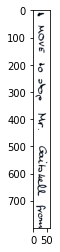

In [11]:

print(dataset[0]['image'].shape)
plt.imshow(dataset[0]['image'].permute(1,2,0))

In [12]:
from ourmodel import IAMModel
# ================================================= MODEL ==============================================================
model = IAMModel(time_step=96,
                 feature_size=512,
                 hidden_size=512,
                 output_size=len(classes) + 1,
                 num_rnn_layers=4)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [13]:
model.to(dev)

IAMModel(
  (cnn): CNN(
    (network): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momen

In [14]:
# ================================================ TRAINING MODEL ======================================================
def fit(model, epochs, train_data_loader, valid_data_loader, lr=1e-3, wd=1e-2, betas=(0.9, 0.999)):
    best_leven = 1000
    opt = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr,
                     weight_decay=wd, betas=betas)
    opt.zero_grad(set_to_none=False)
    len_train = len(train_data_loader)
    loss_func = nn.CTCLoss(reduction='sum', zero_infinity=True, blank=len(classes))
    for i in range(1, epochs + 1):
        # ============================================ TRAINING ========================================================
        batch_n = 1
        train_levenshtein = 0
        len_levenshtein = 0
        for xb, yb, lens in tqdm(train_data_loader,
                                 position=0, leave=True,
                                 file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
            model.train()
            # And the lengths are specified for each sequence to achieve masking
            # under the assumption that sequences are padded to equal lengths.
            input_lengths = torch.full((xb.size()[0],), model.time_step, dtype=torch.long)
            loss_func(model(xb).log_softmax(2).requires_grad_(), yb, input_lengths, lens).backward()
            opt.step()
            opt.zero_grad(set_to_none=False)
            # ================================== TRAINING LEVENSHTEIN DISTANCE =========================================
            if batch_n > (len_train - 5):
                model.eval()
                with torch.no_grad():
                    decoded = model.beam_search_with_lm(xb)
                    
                    for j in range(0, len(decoded)):
                        # We need to find actual string somewhere in the middle of the 'targets'
                        # tensor having tensor 'lens' with known lengths
                        actual = yb.cpu().numpy()[0 + sum(lens[:j]): sum(lens[:j]) + lens[j]]
                        train_levenshtein += leven.distance(''.join([letter for letter in decoded[j]]), ''.join([decode_map.get(letter.item()) for letter in actual[:]]))
                    len_levenshtein += sum(lens).item()

            batch_n += 1
        # ============================================ VALIDATION ======================================================
        model.eval()
        with torch.no_grad():
            val_levenshtein = 0
            target_lengths = 0
            for xb, yb, lens in tqdm(valid_data_loader,
                                     position=0, leave=True,
                                     file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET)):
                decoded = model.beam_search_with_lm(xb)
                for j in range(0, len(decoded)):
                    actual = yb.cpu().numpy()[0 + sum(lens[:j]): sum(lens[:j]) + lens[j]]
                    val_levenshtein += leven.distance(''.join([letter for letter in decoded[j]]), ''.join([decode_map.get(letter.item()) for letter in actual[:]]))
                target_lengths += sum(lens).item()

        print('epoch {}: Train Levenshtein {} | Validation Levenshtein {}'
              .format(i, train_levenshtein / len_levenshtein, val_levenshtein / target_lengths), end='\n')
        # ============================================ SAVE MODEL ======================================================
        if (val_levenshtein / target_lengths) < best_leven:
            torch.save(model.state_dict(), f=str((val_levenshtein / target_lengths) * 100).replace('.', '_') + '_' + 'model.pth')
            best_leven = val_levenshtein / target_lengths

In [15]:
train_batch_size = 60
validation_batch_size = 40
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))
decode_map = {v: k for k, v in dataset.char_dict.items()}
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=train_batch_size, sampler=train_sampler, collate_fn=collate)
validation_loader = DataLoader(dataset, batch_size=validation_batch_size, sampler=valid_sampler, collate_fn=collate)
print("Training...")
# fit(model=model, epochs=200, train_data_loader=train_loader, valid_data_loader=validation_loader)

Training...


In [16]:
# # ============================================ TESTING =================================================================
# def batch_predict(model, valid_dl, up_to):
#     xb, yb, lens = iter(valid_dl).next()
#     model.eval()
#     with torch.no_grad():
#         outs = model.beam_search_with_lm(xb)
#         for i in range(len(outs)):
#             start = sum(lens[:i])
#             end = lens[i].item()
#             corr = ''.join([decode_map.get(letter.item()) for letter in yb[start:start + end]])
#             predicted = ''.join([letter for letter in outs[i]])
#             # ============================================ SHOW IMAGE ==================================================
#             img = xb[i, :, :, :].permute(1, 2, 0).cpu().numpy()
#             img = rgb2gray(img)
#             img = rotate(img, angle=90, clip=False, resize=True)
#             f, ax = plt.subplots(1, 1)
#             mpl.rcParams["font.size"] = 8
#             ax.imshow(img, cmap='gray')
#             mpl.rcParams["font.size"] = 14
#             plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(corr))
#             plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(predicted))
#             f.set_size_inches(10, 3)
#             print('actual: {}'.format(corr))
#             print('predicted:   {}'.format(predicted))
#             if i + 1 == up_to:
#                 break
#     plt.show()


# batch_predict(model=model, valid_dl=validation_loader, up_to=20)

In [17]:
# torch.save(model.state_dict(),  'final_model.pth')

In [18]:
def preprocess_image(image_path, output_size=(800, 63), border_pad=(0, 0)):
    # Read the image using cv2
    image = cv2.imread(image_path)

    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Rotate the image
    image = sk_transform.rotate(image, angle=270, resize=True)

    # If the image is grayscale, convert it to RGB
    if len(image.shape) == 2:
        image = color.gray2rgb(image)

    # Resize the image to the desired output size
    image = sk_transform.resize(image, output_size, anti_aliasing=True)

    # Convert the image to a PIL Image
    image_pil = Image.fromarray((image * 255).astype('uint8'))

    # Apply transformations
    transform = transforms.Compose([
        transforms.Resize(output_size),
        transforms.ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Apply the transformations to the image
    image_tensor = transform(image_pil)

    return image_tensor


def batch_predict_images(model, img_paths, output_size=(800, 63)):
    model.eval()
    input_tensors = []
    for img_path in img_paths:
        input_tensor = preprocess_image(img_path, output_size)
        input_tensors.append(input_tensor)
    input_tensor = torch.stack(input_tensors).to(dev)
    with torch.no_grad():
        outs = model.beam_search_with_lm(input_tensor)
        for idx, out in enumerate(outs):
            predicted = ''.join([letter for letter in out])
            
            img = input_tensor[idx].cpu().permute(1, 2, 0)
            
            # Plot image and print predicted text
            f, ax = plt.subplots(1, 1)
            plt.axis('off')
            plt.tight_layout()
            mpl.rcParams["font.size"] = 8
            img = rotate(img, angle=90, clip=False, resize=True)
            ax.imshow(img, cmap='gray')
            mpl.rcParams["font.size"] = 14
            plt.gcf().text(x=0.1, y=0.1, s=f"Predicted {idx}: " + str(predicted))
            f.set_size_inches(10, 3)
            print(f'predicted {idx}:   {predicted}')
            
    plt.show()

In [19]:
model.load_state_dict(torch.load('final_model.pth', map_location=dev))

<All keys matched successfully>

torch.Size([1, 3, 800, 63])


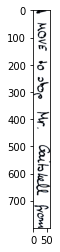

In [20]:
import cv2
# Example usage
image_path = "a01-000u-00.png"
output_size = (800, 63)  # Specify the desired output size
image_tensor = preprocess_image(image_path, output_size).unsqueeze(0).to(dev)
print(image_tensor.shape)  # Output the shape of the resulting tensor
pltimg = image_tensor[0].cpu().permute(1, 2, 0)
# pltimg = rotate(pltimg, angle=0, clip=False, resize=True)
plt.imshow(pltimg)

predicted 0:   a move to stop mr. gaitskell from
predicted 1:   the probe can be evacuated and filled with inert as
predicted 2:   of betti's writing without over-emphasizing


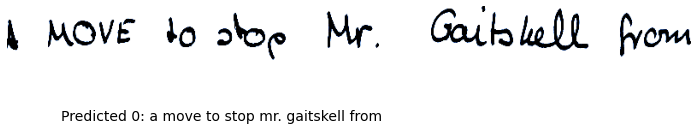

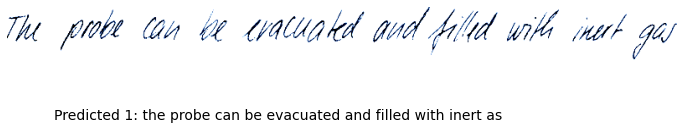

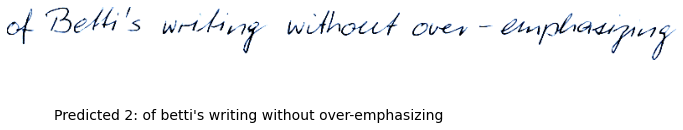

In [21]:
image_paths=['a01-000u-00.png', 'dataset/j01/j01-066/j01-066-00.png', 'sample.png']
batch_predict_images(model, image_paths)

In [22]:
!ls

__pycache__	 chars.txt  final_model.pth  ourmodel.py
a01-000u-00.png  dataset    image1.png	     sample.png


predicted 0:   has made it difficult for corporations to active


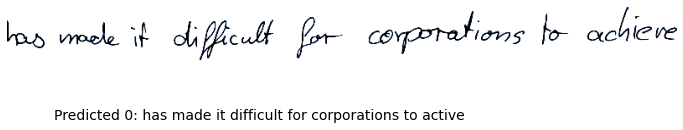

In [23]:
image_paths=['image1.png']
batch_predict_images(model, image_paths)

In [24]:
new_model = IAMModel(time_step=96,
                 feature_size=512,
                 hidden_size=512,
                 output_size=len(classes) + 1,
                 num_rnn_layers=4).to(dev)
new_model.load_state_dict(torch.load('final_model.pth', map_location=dev))

<All keys matched successfully>

predicted 0:   has made it difficult for corporations to active


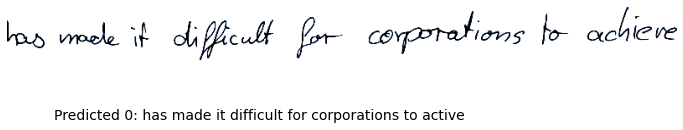

In [25]:
image_paths=['image1.png']
batch_predict_images(new_model, image_paths)

In [26]:
%%writefile app.py
import streamlit as st
import torch
from skimage import io
from skimage import color
import cv2
from skimage import transform as sk_transform
from skimage import color
from skimage.transform import resize, rotate
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
import numpy as np
from torchvision import transforms
from torchvision.transforms import Normalize
from skimage.color import rgba2rgb
from ourmodel import IAMModel

classes = ' !"#&\'()*+,-./0123456789:;?abcdefghijklmnopqrstuvwxyz'

# Device configuration
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to preprocess the input image
def preprocess_image(image_path, output_size=(800, 63), border_pad=(0, 0)):
    # Read the image using cv2
    image = cv2.imread(image_path)

    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Rotate the image
    image = sk_transform.rotate(image, angle=270, resize=True)

    # If the image is grayscale, convert it to RGB
    if len(image.shape) == 2:
        image = color.gray2rgb(image)

    # Resize the image to the desired output size
    image = sk_transform.resize(image, output_size, anti_aliasing=True)

    # Convert the image to a PIL Image
    image_pil = Image.fromarray((image * 255).astype('uint8'))

    # Apply transformations
    transform = transforms.Compose([
        transforms.Resize(output_size),
        transforms.ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Apply the transformations to the image
    image_tensor = transform(image_pil)

    return image_tensor

# Function to predict text from the input image
def predict_text(model, image_path):
    # Load the input image
#     image = io.imread(image_path) 
    
    # Preprocess the image
    input_tensor = preprocess_image(image_path)
    
    # Add batch dimension
    input_tensor = input_tensor.unsqueeze(0)
    
    # Move input tensor to the appropriate device
    input_tensor = input_tensor.to(dev)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Perform inference
    with torch.no_grad():
        outputs = model.beam_search_with_lm(input_tensor)
        predicted_text = ''.join([letter for letter in outputs[0]])
    
    return predicted_text

def handle_file_upload(uploaded_file, filename):
    if uploaded_file is not None:
        with open(filename, "wb") as f:
            f.write(uploaded_file.read())
        return filename
    else:
        return None

# Load the model
model = IAMModel(time_step=96,
                 feature_size=512,
                 hidden_size=512,
                 output_size=len(classes) + 1,
                 num_rnn_layers=4).to(dev)
model.load_state_dict(torch.load('final_model.pth'))

# Streamlit app
st.title('Handwriting Recognition')
st.write('Upload an image and get the predicted text')

# File uploader
uploaded_file = handle_file_upload(st.file_uploader("Upload Image", type=['jpg', 'png']), 'sampel1.png')

if uploaded_file is not None:
    # Display the uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)
    
#     upimg = handle_file_upload(image, 'sampel1.png')
    # Predict text
    predicted_text = predict_text(model, uploaded_file)
    st.write('Predicted Text:', predicted_text)


Writing app.py


In [27]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/kaggle/working/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/kaggle/working/package.json'
npm WARN working No description
npm WARN working No repository field.
npm WARN working No README data
npm WARN working No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 1.753s

3 packages are looking for funding
  run `npm fund` for details

found 1 moderate severity vulnerability
  run `npm audit fix` to fix them, or `npm audit` for details
7m            ......] | postinstall: sill install printInstalled

In [28]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 34.168.2.122


In [ ]:
# !streamlit run ./app.py &> logs.txt & npx localtunnel --port 8501
!streamlit run ./app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.19.2.2:8501
  External URL: http://34.168.2.122:8501

####......] - refresh-package-json:localtunnel: timing action:finalizenpx: installed 22 in 3.528s
your url is: https://major-sides-design.loca.lt
